In [5]:
from textwrap import dedent
from scipy.interpolate import LinearNDInterpolator
from scipy.integrate import fixed_quad
from scipy.stats import beta as beta_distribution
from scipy import interp
from numpy import maximum as npmax
import numpy as np

class SearchProblem(object):
    """
    a class to store a given parameterization of the "offer distribution
    unknown" model
    """
    
    def __init__(self, beta=0.95, c=0.6, F_a=1, F_b=1, G_a=3, G_b=1.2,
                w_max=2, w_grid_size=40, pi_grid_size=40):
        
        self.beta, self.c, self.w_max=beta, c, w_max
        self.F=beta_distribution(F_a, F_b, scale=w_max)
        self.G=beta_distribution(G_a, G_b, scale=w_max)
        self.f, self.g=self.F.pdf, self.G.pdf
        self.pi_min, self.pi_max=1e-3, 1-1e-3
        self.w_grid=np.linspace(0, w_max, w_grid_size)
        self.pi_grid=np.linspace(self.pi_min, self.pi_max, pi_grid_size)
        x, y=np.meshgrid(self.w_grid, self.pi_grid)
        self.grid_points=np.column_stack((x.ravel(1), y.ravel(1)))
        
    def __repr__(self):
        m="SearchProblem(beta={b}, c={c}, F_a={fa}, F_b={fb}, G_a={ga}),"
        m+="G_b={gb}, w_max={wu}, w_grid_size={wgs}, pi_grid_size={pgs}"
        fa, fb=self.F.args
        ga, gb=self.G.args
        return m.format(b=self.beta, c=self.c, fa=fa, fb=fb, ga=ga,
                       gb=gb, wu=self.w_grid.max(), 
                       wgs=self.w_grid.size, pgs=self.pi_grid.size)
    
    def __str__(self):
        m="""\
        SearchProblem(offer distribution unknown):
            -beta(discount factor): {b:g}
            -c(unemployment compensation): {c}
            -F(distribution F): Beta({fa}, {fb:g})
            -G(distribution G): Beta({ga}, {gb:g})
            -w bounds (bounds for wage offers): ({wl:g}, {wu:g})
            -w grid size (number of points in grid for wage): {wgs}
            -pi bounds (bounds for probability of dist f): ({pl:g}, {pu:g})
            -pi grid size (number of points in grid for pi): {pgs}
        """
        fa, fb=self.F.args
        ga, gb=self.G.args
        return dedent(m.format(b=self.beta, c=self.c, fa=fa, fb=fb, ga=ga,
                              gb=gb,
                              wl=self.w_grid.min(), wu=self.w_grid.max(),
                              wgs=self.w_grid.size,
                              pl=self.pi_grid.min(), pu=self.pi_grid.max(),
                              pgs=self.pi_grid.size))
    
    def q(self, w, pi):
        """
        updates pi using bayes' rule and the current wage observation w.
        
        returns
        ----------
        
            new_pi: scalar(float)
                the updated probability
                
        """
        new_pi=1.0/(1+((1-pi)*self.g(w))/(pi*self.f(w)))
        
        #return new_pi when in [pi_min, pi_max] and else end points
        new_pi=np.maximum(np.minimum(new_pi, self.pi_max), self.pi_min)
        
        return new_pi
    
    def res_wage_operator(self, phi):
        """
        
        updates the reservation wage function guess phi via the operator
        Q.
        
        parameters
        ----------
        phi: array_like(float, ndim=1, length=len(pi_grid))
            this is reservation wage guess
            
        returns
        ---------
        new_phi: array_like(float, ndim=1, length=len(pi_grid))
            the updated reservation wage guess.
            
        """
        #==simplify names==#
        beta, c, f, g, q=self.beta, self.c, self.f, self.g, self.q
        #==turn phi into a function==#
        phi_f=lambda p: interp(p, self.pi_grid, phi)
        
        new_phi=np.empty(len(phi))
        for i, pi in enumerate(self.pi_grid):
            def integrand(x):
                "integral expression on right-hand side of operator"
                return npmax(x, phi_f(q(x, pi)))*(pi*f(x)+(1-pi)*g(x))
            integral, error=fixed_quad(integrand, 0, self.w_max)
            new_phi[i]=(1-beta)*c +beta*integral
            
        return new_phi

Iteration    Distance       Elapsed (seconds)
---------------------------------------------
5            2.829e-02      2.104e-01         
10           5.174e-03      4.256e-01         
15           9.652e-04      6.414e-01         


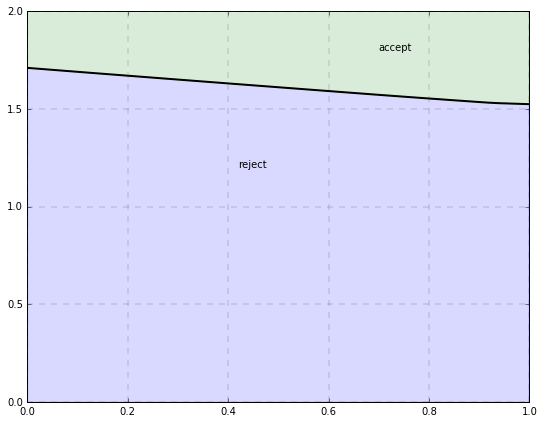

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
from quantecon import compute_fixed_point

sp=SearchProblem(pi_grid_size=50)

phi_init=np.ones(len(sp.pi_grid))
w_bar=compute_fixed_point(sp.res_wage_operator, phi_init)

fig, ax=plt.subplots(figsize=(9, 7))
ax.plot(sp.pi_grid, w_bar, lw=2, color='black')
ax.set_ylim(0, 2)
ax.grid(axis='x', lw=0.25, linestyle='--', color='0.25')
ax.grid(axis='y', lw=0.25, linestyle='--', color='0.25')
ax.fill_between(sp.pi_grid, 0, w_bar, color='blue', alpha=0.15)
ax.fill_between(sp.pi_grid, w_bar, 2, color='green', alpha=0.15)
ax.text(0.42, 1.2, 'reject')
ax.text(0.7, 1.8, 'accept')
plt.show()